# Aligning the LLM with Proximal Policy Optimization (PPO)

This notebook represents the final and most critical stage of the RLHF process. We take our Supervised Fine-Tuned (SFT) model and further refine its behavior using reinforcement learning.

### The Goal:
The objective is to steer the model's generations towards responses that our **Reward Model** deems high-quality, without straying too far from the coherent language patterns learned during the SFT phase.

### Key Components:
* **Policy Model**: The SFT model that we will actively train to maximize rewards.
* **Reward Model**: A frozen "judge" that scores the Policy Model's outputs.
* **Reference Model**: A frozen copy of the original SFT model used to calculate a KL-divergence penalty, preventing the policy from changing too drastically and "forgetting" how to generate good text.

By the end of this process, we will have a PPO-aligned model that is optimized to generate helpful and harmless responses according to our learned reward function.

In [ ]:
# !pip install transformers==4.43.4
# !pip install torch
# !pip install trl==0.11
# !pip install peft
# !pip install tqdm
# !pip install rouge_score
# !pip install --upgrade tqdm

In [61]:
import numpy as np
import os
import torch
from datasets import load_dataset
from tqdm import tqdm
from transformers import AutoTokenizer, GPT2ForSequenceClassification
from transformers import DataCollatorWithPadding
from peft import PeftModel
from trl import PPOConfig, PPOTrainer, AutoModelForCausalLMWithValueHead

### Load Configurations and Dependencies

In [3]:
from ppo_config import BASE_MODEL_NAME, FULL_SFT_CHECKPOINT_PATH, RM_CHECKPOINT_PATH, PPO_CONFIG, DEVICE
from prepare_data import get_sft_datasets

### PPO Trainer Configuration

In [4]:
ppo_config = PPOConfig(**PPO_CONFIG)

### Load Tokenizer and Models 

In [5]:
# Loading the tokenizer for the Full-SFT model (which is the policy)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

In [6]:
RM_CHECKPOINT_PATH

'./reward_model_output_new'

In [7]:
FULL_SFT_CHECKPOINT_PATH

'./full_sft_final_checkpoint'

In [8]:
# Loading the Full-SFT model to be trained (the "policy model")
# We use AutoModelForCausalLMWithValueHead to add a value head for PPO

policy_model = AutoModelForCausalLMWithValueHead.from_pretrained(
    FULL_SFT_CHECKPOINT_PATH,
    is_trainable=True,
    device_map=DEVICE
).to(DEVICE)

ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(
    FULL_SFT_CHECKPOINT_PATH,
    device_map=DEVICE
).to(DEVICE)


# Load the Reward Model (frozen, for evaluation)

reward_model = GPT2ForSequenceClassification.from_pretrained(RM_CHECKPOINT_PATH, num_labels=1).to(DEVICE)
reward_model.eval()

reward_model.config.pad_token_id = tokenizer.pad_token_id

print("All models loaded successfully!")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


All models loaded successfully!


### Prepare the Dataset

In [9]:
train_dataset, test_dataset = get_sft_datasets("./my-local-dataset/")

Loading and processing dataset
Dataset split into 31485 training examples and 1658 testing examples.
Dataset processing complete.


In [10]:
train_dataset

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 31485
})

In [11]:
test_dataset

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 1658
})

In [12]:
ppo_train_dataset = train_dataset.rename_column("prompt", "query")
ppo_test_dataset = test_dataset.rename_column("prompt", "query")

In [13]:
def tokenize_prompt(sample):
    tokenized = tokenizer(sample["query"], truncation=True, max_length=512)
    return tokenized

In [14]:
ppo_train_dataset = ppo_train_dataset.map(tokenize_prompt, remove_columns=ppo_train_dataset.features)
ppo_test_dataset = ppo_test_dataset.map(tokenize_prompt, remove_columns=ppo_test_dataset.features)

Map:   0%|          | 0/31485 [00:00<?, ? examples/s]

Map:   0%|          | 0/1658 [00:00<?, ? examples/s]

In [15]:
ppo_train_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 31485
})

In [16]:
print(tokenizer.decode(ppo_test_dataset[0]['input_ids']))

### Instruction:
What are the different types of loans I can apply for to purchase a house.

### Response:



### Initialize the PPOTrainer

In [17]:
# The PPOTrainer needs the policy model, a reference model (it creates one automatically if None),
# the dataset of prompts, and the tokenizer.

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

ppo_trainer = PPOTrainer(
    config=ppo_config,
    model=policy_model,
    ref_model=ref_model,
    tokenizer=tokenizer,
    dataset=ppo_train_dataset,
    data_collator=data_collator
)
print("PPOTrainer initialized.")

PPOTrainer initialized.


In [18]:
generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 150,
}

In [19]:
test_batch = next(iter(ppo_trainer.dataloader))

In [20]:
# See keys
print("Batch keys:", test_batch.keys())

# Inspect shapes
for k, v in test_batch.items():
    print(k, v.shape)

# Decode one sample
print("\nDecoded prompt:")
print(tokenizer.decode(test_batch["input_ids"][0]))

Batch keys: dict_keys(['input_ids', 'attention_mask'])
input_ids torch.Size([16, 39])
attention_mask torch.Size([16, 39])

Decoded prompt:
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>### Instruction:
What are some simple steps I can take to improve my diet.

### Response:



In [21]:
test_query_tensors = [q for q in test_batch["input_ids"]]
test_response_tensors = ppo_trainer.generate(test_query_tensors, return_prompt=False, **generation_kwargs)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [22]:
print(len(test_response_tensors))             
print(test_response_tensors[0].shape)         
print(tokenizer.decode(test_response_tensors[0]))

16
torch.Size([150])
1. Regularly include at least 1 cup of whole grains, 3/4 cup of lean proteins, 3/4 cup of fruits and vegetables, and 3/4 cup of healthy fats. 
2. Reduce sodium, saturated fat, and added sugars, as well as calorie counting and avoid processed and sugary foods. 
3. Limit your intake of processed meats and limit processed sweeteners and take time to not consume caffeine and smoke. 
4. Eat as many avocados as you can during the day and limit processed while you are still alive. 
5. Drink plenty of water throughout the day, but clean your teeth to ensure you’re properly hydrated. 
6. Exercise regularly to help


In [23]:
tokenizer.batch_decode(test_response_tensors, skip_special_tokens=True)[0]

'1. Regularly include at least 1 cup of whole grains, 3/4 cup of lean proteins, 3/4 cup of fruits and vegetables, and 3/4 cup of healthy fats. \n2. Reduce sodium, saturated fat, and added sugars, as well as calorie counting and avoid processed and sugary foods. \n3. Limit your intake of processed meats and limit processed sweeteners and take time to not consume caffeine and smoke. \n4. Eat as many avocados as you can during the day and limit processed while you are still alive. \n5. Drink plenty of water throughout the day, but clean your teeth to ensure you’re properly hydrated. \n6. Exercise regularly to help'

In [24]:
test_batch["response"] = tokenizer.batch_decode(test_response_tensors, skip_special_tokens=True) 

In [25]:
test_prompt_texts = tokenizer.batch_decode(test_query_tensors, skip_special_tokens=True)

In [26]:
test_prompt_texts[0]

'### Instruction:\nWhat are some simple steps I can take to improve my diet.\n\n### Response:\n'

In [27]:
test_texts_for_rm = [q + r for q, r in zip(test_prompt_texts, test_batch["response"])]

In [28]:
len(test_texts_for_rm)

16

In [29]:
print("--- First combined text for Reward Model ---")
print(test_texts_for_rm[0])

--- First combined text for Reward Model ---
### Instruction:
What are some simple steps I can take to improve my diet.

### Response:
1. Regularly include at least 1 cup of whole grains, 3/4 cup of lean proteins, 3/4 cup of fruits and vegetables, and 3/4 cup of healthy fats. 
2. Reduce sodium, saturated fat, and added sugars, as well as calorie counting and avoid processed and sugary foods. 
3. Limit your intake of processed meats and limit processed sweeteners and take time to not consume caffeine and smoke. 
4. Eat as many avocados as you can during the day and limit processed while you are still alive. 
5. Drink plenty of water throughout the day, but clean your teeth to ensure you’re properly hydrated. 
6. Exercise regularly to help


In [30]:
test_rm_inputs = tokenizer(test_texts_for_rm, padding=True, truncation=True, return_tensors="pt").to(DEVICE)

In [31]:
print(test_rm_inputs.keys())

dict_keys(['input_ids', 'attention_mask'])


In [32]:
print(tokenizer.decode(test_rm_inputs[0].ids))

<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>### Instruction:
What are some simple steps I can take to improve my diet.

### Response:
1. Regularly include at least 1 cup of whole grains, 3/4 cup of lean proteins, 3/4 cup of fruits and vegetables, and 3/4 cup of healthy fats. 
2. Reduce sodium, saturated fat, and added sugars, as well as calorie counting and avoid processed and sugary foods. 
3. Limit your intake of processed meats and limit processed sweeteners and take time to not consume caffeine and smoke. 
4. Eat as many avocados as you can during the day and limit processed while you are still alive. 
5. Drink plenty of water throughout the day, but clean your teeth to ensure you’re properly hydrated. 
6. Exercise regularly to help


In [33]:
with torch.no_grad():
    test_rewards = reward_model(**test_rm_inputs).logits

In [34]:
test_rewards

tensor([[-5.4809],
        [-4.3386],
        [-3.1747],
        [-3.7182],
        [ 1.8712],
        [-6.3795],
        [-5.3255],
        [-1.0670],
        [-5.8739],
        [-2.1459],
        [-6.7246],
        [-5.6839],
        [-4.0805],
        [-1.4660],
        [-2.4351],
        [-2.3722]], device='cuda:0')

In [35]:
test_rewards = list(test_rewards)

In [36]:
test_stats = ppo_trainer.step(test_query_tensors, test_response_tensors, test_rewards)

In [37]:
test_stats

{'objective/kl': 0.0,
 'objective/kl_dist': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'objective/logprobs': array([[-3.3079712e+01, -1.5716061e+01, -1.6440786e+01, ...,
         -5.5458542e-02, -1.1243004e+00, -1.2873931e+00],
        [-3.3079712e+01, -1.5716061e+01, -1.6440786e+01, ...,
         -8.5730290e-01, -7.3192105e+00, -3.1852951e+00],
        [-3.3079712e+01, -1.5716061e+01, -1.6440786e+01, ...,
         -1.7917137e+00, -1.1357296e+00, -4.1500254e+00],
        ...,
        [-3.3079712e+01, -1.5716061e+01, -1.6440786e+01, ...,
         -1.2230125e-04, -1.9837071e+00, -6.5100050e-01],
        [-3.3079712e+01, -1.5716061e+01, -1.6440786e+01, ...,
         -3.6211004e+00, -1.8142107e-01, -7.8855944e+00],
        [-3.3079712e+01, -1.5716061e+01, -1.6440786e+01, ...,
         -4.3350916e+00, -1.9953432e+00, -8.4099588e+00]], dtype=float32),
 'objective/ref_logprobs': array([[-3.3079712e+01, -1.5716061e+01, -1.6440786e+01, ...,
 

In [38]:
def interpret_ppo_stats(stats):
    
    print("--- PPO Step Analysis ---")
    
    # --- Reward & Performance Metrics ---
    print("\n--- Reward & Performance ---")
    mean_scores = stats.get('ppo/mean_scores', 0)
    print(f"Mean Reward Score: {mean_scores:.4f}  (Main objective)")
    
    # --- Loss Components ---
    print("\n--- Loss Components ---")
    policy_loss = stats.get('ppo/loss/policy', 0)
    value_loss = stats.get('ppo/loss/value', 0)
    total_loss = stats.get('ppo/loss/total', 0)
    print(f"Total Loss: {total_loss:.4f}")
    print(f"  - Policy Loss: {policy_loss:.4f} (Drives the policy to get higher rewards)")
    print(f"  - Value Loss:  {value_loss:.4f} (Improves the value function's predictions)")
    
    # --- Policy Behavior & Stability ---
    print("\n--- Policy Behavior & Stability ---")
    kl_div = stats.get('objective/kl', 0)
    clip_frac = stats.get('ppo/policy/clipfrac', 0)
    entropy = stats.get('ppo/policy/entropy', 0)
    print(f"KL Divergence: {kl_div:.4f} (Penalty to keep the policy stable. Should be low.)")
    print(f"Entropy: {entropy:.4f} (Measure of policy randomness. Prevents premature convergence.)")
    print(f"Clipping Fraction: {clip_frac:.4f} (Fraction of updates clipped. High values > 0.3 may suggest instability or LR is too high.)")
    
    # --- Value Function Diagnostics ---
    print("\n--- Value Function Diagnostics ---")
    v_error = stats.get('ppo/val/error', 0)
    var_explained = stats.get('ppo/val/var_explained', 0)
    print(f"Value Prediction Error: {v_error:.4f} (How wrong the value function's predictions are.)")
    print(f"Explained Variance: {var_explained:.4f} (How well the value fn predicts returns. Target is 1.0. Negative is BAD)")

    # --- Timing ---
    print("\n--- Timing ---")
    total_time = stats.get('time/ppo/total', 0)
    print(f"Total Time for Step: {total_time:.4f} seconds")
    
    print("\n" + "="*40)

In [39]:
interpret_ppo_stats(test_stats)

--- PPO Step Analysis ---

--- Reward & Performance ---
Mean Reward Score: -3.6497  (Main objective)

--- Loss Components ---
Total Loss: 0.2220
  - Policy Loss: -0.0312 (Drives the policy to get higher rewards)
  - Value Loss:  2.5321 (Improves the value function's predictions)

--- Policy Behavior & Stability ---
KL Divergence: 0.0000 (Penalty to keep the policy stable. Should be low.)
Entropy: 2.0824 (Measure of policy randomness. Prevents premature convergence.)
Clipping Fraction: 0.2204 (Fraction of updates clipped. High values > 0.3 may suggest instability or LR is too high.)

--- Value Function Diagnostics ---
Value Prediction Error: 3.9583 (How wrong the value function's predictions are.)
Explained Variance: -3.8459 (How well the value fn predicts returns. Target is 1.0. Negative is BAD)

--- Timing ---
Total Time for Step: 2.5103 seconds



In [46]:
SAVE_DIR = "./ppo_checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

MAX_STEPS = 100
SAVE_INTERVAL = 20

In [47]:
print("\nStarting PPO training...")
for step, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    query_tensors = [q for q in batch["input_ids"]]

    # 1. Generate a response from the policy model (the "rollout")
    response_tensors = ppo_trainer.generate(query_tensors, return_prompt=False, **generation_kwargs)
    batch["response"] = tokenizer.batch_decode(response_tensors)

    # 2. Score the response with the Reward Model
    # We need to format the text as "prompt + response" for the RM
    prompt_texts = tokenizer.batch_decode(query_tensors, skip_special_tokens=True)
    texts_for_rm = [q + r for q, r in zip(prompt_texts, batch["response"])]
    
    rm_inputs = tokenizer(texts_for_rm, padding=True, truncation=True, return_tensors="pt").to(DEVICE)
    
    with torch.no_grad():
        # The reward is a single score for each response
        rewards = reward_model(**rm_inputs).logits
        
    # 3. Perform the PPO optimization step
    # the trainer calculates the complex PPO loss and updates the policy model weights.
    stats = ppo_trainer.step(query_tensors, response_tensors, list(rewards))
    
    # Log the stats
    ppo_trainer.log_stats(stats, batch, rewards)
    
    if step % SAVE_INTERVAL == 0 and step > 0:
        save_path = os.path.join(SAVE_DIR, f"step_{step}")
        ppo_trainer.model.save_pretrained(save_path)
        tokenizer.save_pretrained(save_path)
        print(f"Checkpoint saved at {save_path}")
    
    if step >= MAX_STEPS:
        break

print("PPO training complete!")


Starting PPO training...


21it [02:29,  7.60s/it]

Checkpoint saved at ./ppo_checkpoints/step_20


41it [04:51,  7.63s/it]

Checkpoint saved at ./ppo_checkpoints/step_40


61it [07:12,  7.66s/it]

Checkpoint saved at ./ppo_checkpoints/step_60


81it [09:35,  7.65s/it]

Checkpoint saved at ./ppo_checkpoints/step_80


100it [11:57,  7.17s/it]

Checkpoint saved at ./ppo_checkpoints/step_100
PPO training complete!


In [48]:
ppo_trainer.model.save_pretrained("ppo_checkpoints/ppo_final")

## Evaluation

In [62]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from trl import AutoModelForCausalLMWithValueHead
import json
import os
from prepare_data import get_sft_datasets

In [77]:
BASE_MODEL_NAME = "gpt2"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FULL_SFT_CHECKPOINT_PATH = "./full_sft_final_checkpoint"
PPO_CHECKPOINT = "./ppo_checkpoints/ppo_final/"
OUTPUTS_DIR = "outputs"

In [82]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

# Load Base Model
print("Loading Base Model (gpt2)...")
base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_NAME).to(DEVICE)
base_model.eval()

# Load Full SFT Model
print(f"Loading SFT Model from {FULL_SFT_CHECKPOINT_PATH}...")
sft_model = AutoModelForCausalLM.from_pretrained(FULL_SFT_CHECKPOINT_PATH).to(DEVICE)
sft_model.eval()

# Load PPO Model
print(f"Loading PPO Model from {PPO_CHECKPOINT}...")
ppo_model = AutoModelForCausalLM.from_pretrained(PPO_CHECKPOINT, local_files_only=True).to(DEVICE)
ppo_model.eval()

print("\nAll models loaded successfully!")

Loading Base Model (gpt2)...
Loading SFT Model from ./full_sft_final_checkpoint...
Loading PPO Model from ./ppo_checkpoints/ppo_final/...


Some weights of the model checkpoint at ./ppo_checkpoints/ppo_final/ were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



All models loaded successfully!


In [83]:
_, test_dataset = get_sft_datasets('my-local-dataset/')

sample_indices = [10, 20, 50]
sample_prompts = [test_dataset[i]['prompt'] for i in sample_indices]
ground_truths = [test_dataset[i]['completion'] for i in sample_indices]

Loading and processing dataset
Dataset split into 31485 training examples and 1658 testing examples.
Dataset processing complete.


In [84]:
models_to_compare = {
    "Base Model": base_model,
    "Full SFT Model": sft_model,
    "PPO Model": ppo_model,
}
all_comparisons = []

In [85]:
print("\n" + "="*50)
print("--- GENERATING MODEL COMPARISONS ---")
print("="*50)

for i, prompt_text in enumerate(sample_prompts):
    # Store results for this prompt
    comparison_data = {
        "prompt": prompt_text,
        "ground_truth": ground_truths[i]
    }
    
    print(f"\n\n--- COMPARISON FOR PROMPT {i+1}/{len(sample_prompts)} ---")
    print(f"PROMPT:\n{prompt_text}")
    print("\n" + "-"*30)
    print(f"GROUND TRUTH:\n{ground_truths[i]}")
    print("-"*30)

    for name, model in models_to_compare.items():
        # Tokenize the single prompt
        inputs = tokenizer(prompt_text, return_tensors="pt").to(DEVICE)
        
        # Generate a response
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=150,
                temperature=0.7,
                do_sample=False,
                repetition_penalty=1.2
            )
        
        # Decode and clean the response
        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_part = full_response[len(prompt_text):].strip()
        
        # Print for comparison
        print(f"\n--- {name} Response ---")
        print(generated_part)
        
        # Save the response
        comparison_data[f"{name.lower().replace(' ', '_')}_response"] = generated_part
    
    all_comparisons.append(comparison_data)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- GENERATING MODEL COMPARISONS ---


--- COMPARISON FOR PROMPT 1/3 ---
PROMPT:
### Instruction:
What is the best way to clean and care for leather shoes.

### Response:


------------------------------
GROUND TRUTH:
The best way to clean and care for leather shoes is to start by using a leather cleaner specifically designed for the type of leather used. This will not only help keep them clean, but also help protect the leather from the elements. Once cleaned, apply a leather conditioner to help keep the leather soft and supple. Finally, use a leather polish to help add luster and protection. Reapply the products every couple of months to keep your shoes looking their best.
------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Base Model Response ---
I have a question about how I can help you with your shoe cleaning needs, so please feel free (or at least ask me) if there are any questions or concerns that need addressing here on this site!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Full SFT Model Response ---
The most effective way to properly carefor leather shoes is to use a soft, non-abrasive cleaning solution such as vinegar or water. Apply it gently on the affected area of your shoe before using it again. If the surface is too dry, you may need additional treatment like rubbing alcohol with a damp cloth or sponge. Be sure not over-breathing will damage the leather. Finally be sure that the sole is free from dirt and debris while wearing the shoes. Make sure all surfaces are cleaned thoroughly after each wear. Lastly make sure they have been washed in cold water soapy water does not enter the leather. Good luck. Enjoy your new pair!  Update 2 - May 2020 The following information has changed since I last updated this


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- PPO Model Response ---
The best way of cleaning, caring or conserving your leather shoe are to use a soft cloth such as cotton swabs with gentle pressure-treating soap; use a leather conditioner like leather cleaner or leather oil; and keep them in good condition. Additionally, you should regularly wash your shoes before use and make sure they are not stained or damaged. Finally, be sure that you follow all instructions carefully and thoroughly. Good luck. Keep in mind that it's important to maintain good hygiene habits while wearing leather shoes. It may also help to consider using an alternative method of care. Consider consulting a professional if you have any questions. Lastly, don't forget to take regular breaks throughout the day to rest and rejuvenate your skin. With proper maintenance


--- COMPARISON FOR PROMPT 2/3 ---
PROMPT:
### Instruction:
I want to shop for a new car. What should I look for in price, features, and safety.

### Response:


----------------------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Base Model Response ---
"The best thing about this is that it's not just the cost of buying an old one." - Mike "It was great! It took me out into my own world!" – Chris "This has been fun getting started with cars from different manufacturers so far but if you're looking at any other brand or model then go ahead...it will be worth your while". -- Michael "You can't beat these guys on pricing because they are all very good quality vehicles..." — John "They have some really cool stuff too..they make sure everything looks like what we expect them (and their) prices....you'll never get bored by anything else here!! :) Thanks again!!"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Full SFT Model Response ---
You will need to consider the type of vehicle you are looking at as well your budget and preferences when shopping for a new car. Consider factors such as fuel economy, reliability, cost, maintenance, performance, etc. You may also be able find some good deals on different models or accessories if you're interested in those items. Additionally check out reviews from other customers who have used similar cars before purchasing one so that you can compare prices between them. Finally make sure it is safe to take any necessary precautions while driving with the new car; this could include checking mirrors regularly, taking off lights whenever possible, avoiding side mirrors during drive-throughs, using an emergency brake system (eBI), and not turning left until after dark. Good luck.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- PPO Model Response ---
You should consider looking at the overall cost of your car as well as the potential benefits of having a good reputation. Consider researching different dealerships and comparing prices from different manufacturers. You may also be able to find deals on used cars or other luxury items. Finally, make sure you check with your local government and insurance companies to ensure you are getting quality service. Good luck. It is important to have fun while shopping and don't forget to take pride in being honest and trustworthy. With all of this in mind, it's best to research any available options and compare prices before making any decisions. Be patient and keep up with sales and promotions so you can get an edge in buying something that will last long-term. Don’t let too


--- COMPARISON FOR PROMPT 3/3 ---
PROMPT:
### Instruction:
What is the atomic structure of water.

### Response:


------------------------------
GROUND TRUTH:
The atomic structure of water i

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Base Model Response ---
- The following question was asked by a member of the committee on nuclear energy, and he answered it in an interesting way (see below). He said that there are two types - one type has to be very large for its size to have any effect; another kind can only affect small areas or regions where they don't exist at all but which may not necessarily cause problems with other parts of the system as well. This means we need more information about what kinds each element does when exposed to air pressure above 100 m/s than would otherwise occur if you were trying hard enough without having access into your own body's internal organs such cells from outside sources like blood vessels etc. So I think this answer should give us some idea how much radiation our bodies


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Full SFT Model Response ---
The atomic shape and size are determined by the chemical formula A = 2πr^2, where r is a radius and b is an atom. The ratio of the two elements in water is 0.8 to 1. This means that when the atoms interact with each other, they form a single nucleus which contains all the energy it needs for its production. Water has four basic forms, hydrogen (H), oxygen(O) or carbon dioxide; nitrogen gas (NO), and oxygen-rich gases such as sulfuric acid and chlorine. Hydrogen is the most abundant element on Earth, making it the only one found in nature. Oxygen is the second most abundant element, followed closely behind by carbon dioxide. Carbon dioxide is the third most abundant

--- PPO Model Response ---
The basic atomicity and its chemical composition are determined by their respective atoms, while other elements such as hydrogen or helium have a different arrangement in which they form one substance called an "atomic" (or equivalence) molecule; this includes all 

In [87]:
output_file_path = "final_model_comparisons.json"
with open(output_file_path, "w") as f:
    json.dump(all_comparisons, f, indent=4)

In [92]:
import logging
from transformers import logging as transformers_logging
transformers_logging.set_verbosity_error()

In [93]:
ppo_predictions = []
ppo_references = []

print("\nGenerating predictions on the test set...")

batch_size = 16
for i in tqdm(range(0, len(test_dataset), batch_size)):
    batch = test_dataset[i:i+batch_size]
    prompts = batch['prompt']
    ground_truths = batch['completion']
    
    # Tokenize prompts
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(DEVICE)
    
    with torch.no_grad():
        outputs = ppo_model.generate(
            **inputs,
            max_new_tokens=100,
            num_beams=3,
            temperature=0.6,
            do_sample=False,
            repetition_penalty=1.2
        )
    
    # Decode and clean up the generated text
    decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    
    # Remove the original prompt from the generated text
    cleaned_predictions = [out[len(prompt):].strip() for out, prompt in zip(decoded_outputs, prompts)]
    
    # Add to lists
    ppo_predictions.extend(cleaned_predictions)
    ppo_references.extend(ground_truths)


Generating predictions on the test set...


100%|██████████| 104/104 [02:59<00:00,  1.72s/it]


In [94]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

all_scores = []
for ref, pred in zip(ppo_references, ppo_predictions):
    score = scorer.score(ref, pred)
    all_scores.append(score)

In [95]:
rouge1 = [s["rouge1"].fmeasure for s in all_scores]
rouge2 = [s["rouge2"].fmeasure for s in all_scores]
rougeL = [s["rougeL"].fmeasure for s in all_scores]

print("ROUGE-1:", np.mean(rouge1))
print("ROUGE-2:", np.mean(rouge2))
print("ROUGE-L:", np.mean(rougeL))

ROUGE-1: 0.33653781264982163
ROUGE-2: 0.1389637210519761
ROUGE-L: 0.251543377242404


In [ ]:
with open("ppo_predictions.json", "w") as f:
    json.dump({
        "predictions": ppo_predictions,
        "references": ppo_references
    }, f, indent=4)

Metrics saved to sft_ppo_performance_metrics.csv
Plot saved to model_performance_comparison.png


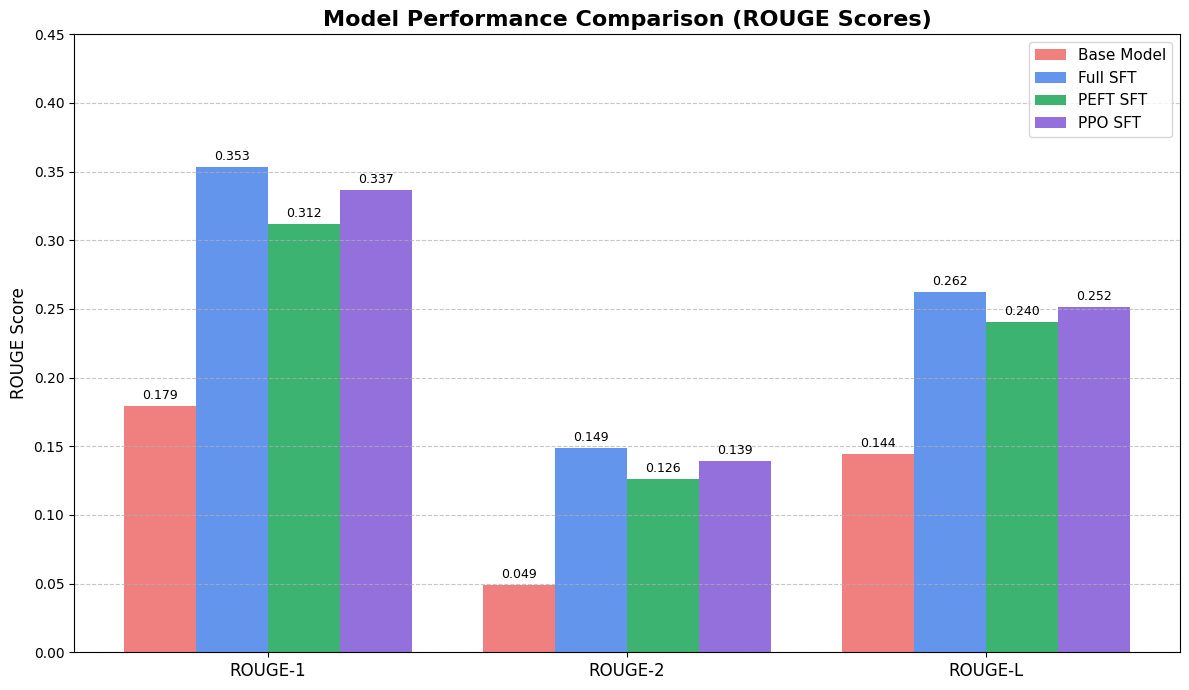

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Data Preparation ---
data = {
    "Metric": ["ROUGE-1", "ROUGE-2", "ROUGE-L"],
    "Base Model": [0.1793, 0.0492, 0.1444],
    "Full SFT": [0.3534, 0.1487, 0.2622],
    "PEFT SFT": [0.3117, 0.1260, 0.2405],
    "PPO SFT": [0.3365, 0.1390, 0.2515]
}
df = pd.DataFrame(data)

# --- 2. Save the metrics to a CSV file ---
csv_filename = 'sft_ppo_performance_metrics.csv'
df.to_csv(csv_filename, index=False, float_format='%.4f')
print(f"Metrics saved to {csv_filename}")


# --- 3. Plotting the Comparison Chart ---
fig, ax = plt.subplots(figsize=(12, 7), dpi=100)


# Set bar positions and width for four groups
x = np.arange(len(df['Metric']))
width = 0.2  # Adjusted width for four bars

# Plot the bars for each model with new positions
rects1 = ax.bar(x - 1.5*width, df['Base Model'], width, label='Base Model', color='lightcoral')
rects2 = ax.bar(x - 0.5*width, df['Full SFT'], width, label='Full SFT', color='cornflowerblue')
rects3 = ax.bar(x + 0.5*width, df['PEFT SFT'], width, label='PEFT SFT', color='mediumseagreen')
rects4 = ax.bar(x + 1.5*width, df['PPO SFT'], width, label='PPO SFT', color='mediumpurple')

# Add labels, title, and ticks
ax.set_ylabel('ROUGE Score', fontsize=12)
ax.set_title('Model Performance Comparison (ROUGE Scores)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['Metric'], fontsize=12)
ax.legend(fontsize=11)
ax.set_ylim(0, 0.45) # Set Y-axis limit for better visual comparison
ax.grid(axis='y', linestyle='--', alpha=0.7) # Add a light grid for readability

# Add data labels on top of each bar
ax.bar_label(rects1, padding=3, fmt='%.3f', fontsize=9)
ax.bar_label(rects2, padding=3, fmt='%.3f', fontsize=9)
ax.bar_label(rects3, padding=3, fmt='%.3f', fontsize=9)
ax.bar_label(rects4, padding=3, fmt='%.3f', fontsize=9)

# Final layout adjustments, save the figure, and show the plot
fig.tight_layout()
plot_filename = "model_performance_comparison.png"
plt.savefig(plot_filename)
print(f"Plot saved to {plot_filename}")
plt.show()

In [101]:
import torch
from transformers import AutoModelForCausalLM, GPT2ForSequenceClassification, AutoTokenizer
from peft import PeftModel
import json
import os
from tqdm import tqdm
from prepare_data import get_sft_datasets

# --- 1. Setup: Define Paths and Load All Models & Tokenizers ---

BASE_MODEL_NAME = "gpt2"
FULL_SFT_CHECKPOINT_PATH = "full_sft_final_checkpoint/"
PPO_CHECKPOINT = "ppo_checkpoints/ppo_final/"
RM_CHECKPOINT = "reward_model_output_new/"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [102]:
# Load the main tokenizer for generation (with left-padding)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token


# Load Base Model
print("Loading Base Model (gpt2)...")
base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_NAME).to(DEVICE)
base_model.eval()

# Load Full SFT Model
print(f"Loading SFT Model from {FULL_SFT_CHECKPOINT_PATH}...")
sft_model = AutoModelForCausalLM.from_pretrained(FULL_SFT_CHECKPOINT_PATH).to(DEVICE)
sft_model.eval()

# Load PPO Model
print(f"Loading PPO Model from {PPO_CHECKPOINT}...")
ppo_model = AutoModelForCausalLM.from_pretrained(PPO_CHECKPOINT, local_files_only=True).to(DEVICE)
ppo_model.eval()


# --- Load the trained Reward Model ---
print(f"Loading Reward Model from {RM_CHECKPOINT}...")
rm_base_model = GPT2ForSequenceClassification.from_pretrained(BASE_MODEL_NAME, num_labels=1)
reward_model = PeftModel.from_pretrained(rm_base_model, RM_CHECKPOINT).to(DEVICE)
reward_model.eval()

print("\nAll models loaded successfully!")

Loading Base Model (gpt2)...
Loading SFT Model from full_sft_final_checkpoint/...
Loading PPO Model from ppo_checkpoints/ppo_final/...
Loading Reward Model from reward_model_output_new/...

All models loaded successfully!


In [103]:
def get_reward_score(prompt, response, rm, rm_tokenizer):
    """Calculates a reward score for a given prompt and response."""
    text_for_rm = prompt + response
    
    inputs = rm_tokenizer(text_for_rm, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(DEVICE)
    
    with torch.no_grad():
        score = rm(**inputs).logits[0].item()
    return score

In [109]:
_, test_dataset = get_sft_datasets('my-local-dataset/')
sample_indices = [10, 20, 50, 60, 70, 80, 90, 100]
sample_prompts = [test_dataset[i]['prompt'] for i in sample_indices]
ground_truths = [test_dataset[i]['completion'] for i in sample_indices]

Loading and processing dataset
Dataset split into 31485 training examples and 1658 testing examples.
Dataset processing complete.


In [104]:
models_to_compare = {
    "Base Model": base_model,
    "SFT Model": sft_model,
    "PPO Model": ppo_model,
}
all_comparisons = []

print("\n" + "="*50)
print("--- GENERATING MODEL COMPARISONS ---")
print("="*50)

for i, prompt_text in tqdm(enumerate(sample_prompts)):
    comparison_data = {"prompt": prompt_text, "ground_truth": ground_truths[i]}
    
    print(f"\n\n--- COMPARISON FOR PROMPT {i+1}/{len(sample_prompts)} ---")
    print(f"PROMPT:\n{prompt_text}")
    print("\n" + "-"*30)

    for name, model in models_to_compare.items():
        inputs = tokenizer(prompt_text, return_tensors="pt").to(DEVICE)
        
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=150, temperature=0.7, do_sample=True, repetition_penalty=1.2)
        
        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_part = full_response[len(prompt_text):].strip()
        
        # --- Get reward score for the generated response ---
        reward_score = get_reward_score(prompt_text, generated_part, reward_model, tokenizer)
        
        # Print for side-by-side comparison
        print(f"\n--- {name} Response (Reward Score: {reward_score:.2f}) ---")
        print(generated_part)
        
        # Save the response and its reward
        comparison_data[f"{name.lower().replace(' ', '_')}_response"] = generated_part
        comparison_data[f"{name.lower().replace(' ', '_')}_reward"] = reward_score
    
    all_comparisons.append(comparison_data)

Loading and processing dataset
Dataset split into 31485 training examples and 1658 testing examples.
Dataset processing complete.

--- GENERATING MODEL COMPARISONS ---


--- COMPARISON FOR PROMPT 1/8 ---
PROMPT:
### Instruction:
What is the best way to clean and care for leather shoes.

### Response:


------------------------------

--- Base Model Response (Reward Score: -0.14) ---
"I have a lot of questions about my Leather Shoes cleaning program, but I can't find anything on this website that details how you will do it or which steps are necessary."
...and finally an answer! My response was great as well.. :D Thankyou guys!! The process itself has been extremely useful since we started so far because everything worked perfectly in theory (i've never had any problems with using them), except when i put pressure over rubbing against your foot while walking through woods/gravel etc...but after several hours washing each shoe every time there would be some weird odour coming out from un


--- SFT Model Response (Reward Score: 0.16) ---
-Finance and finance analysts  -Research, analysis & development specialists  1) Data analyst -Programming experts 2), IT systems administrator (H&S) -Software developers 3)(Designers and technical/technicians) 4) Consulting Engineer or software developer 5(Technology engineer)  Other roles such as web designer, data analyst, product manager, customer service representative at companies like Google, Microsoft, Apple etc. The tech sector is a highly competitive field with many different industries vying for each job. In order to find out which type would be considered an ideal candidate for every career field, search engine optimization (SEO) algorithms were used to create more detailed profiles of potential employers based on their skills, experience level, location, network capabilities

--- PPO Model Response (Reward Score: 2.66) ---
In order to find job opportunities and career paths, it is important for employers looking into softwar


--- PPO Model Response (Reward Score: 2.95) ---
One type that you should follow for losing fat and unhealthy weight is a balanced, nutritious plan based on eating whole foods such as fruits & vegetables; limiting your intake too much or too little can help to maintain a healthy weight control regime. Additionally, make sure to try to limit processed and sugary foods and avoid sugary beverages. Finally, don't forget to include in-vitro meals with healthy fats like nuts and seeds. This will promote good digestion and reduce your risk factors for overeating. It's important to take the time to adjust your dietary habits so as not become overweight or obese. Good luck. Now, it’s best to reach out to friends and family who may have experienced anorexia. You could also consider


--- COMPARISON FOR PROMPT 8/8 ---
PROMPT:
### Instruction:
What are the most common mistakes people make when color coordinating their wardrobes.

### Response:


------------------------------

--- Base Model Respo

In [105]:
output_file_path = "final_model_comparisons_with_rewards.json"
with open(output_file_path, "w") as f:
    json.dump(all_comparisons, f, indent=4)

In [110]:
_, test_dataset = get_sft_datasets('my-local-dataset/')

Loading and processing dataset
Dataset split into 31485 training examples and 1658 testing examples.
Dataset processing complete.


In [111]:
# Take all prompts and completions
prompts = [item['prompt'] for item in test_dataset]
ground_truths = [item['completion'] for item in test_dataset]

print(len(prompts), len(ground_truths))

1658 1658


In [114]:
models_to_compare = {
    "Base Model": base_model,
    "SFT Model": sft_model,
    "PPO Model": ppo_model,
}

# --- 1. Initialize a dictionary to store lists of scores ---
reward_scores = {name: [] for name in models_to_compare.keys()}

print("\n--- Generating and Scoring Responses for All Models ---")

prompts_for_scoring = test_dataset['prompt'][:200]

for prompt_text in tqdm(prompts_for_scoring, desc="Scoring Test Set"):
    for name, model in models_to_compare.items():
        # Generate a response
        inputs = tokenizer(prompt_text, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=150,
                temperature=0.6,
                do_sample=True,
                repetition_penalty=1.2
            )
        
        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_part = full_response[len(prompt_text):].strip()
        
        # Get reward score and append to the list for the current model
        score = get_reward_score(prompt_text, generated_part, reward_model, tokenizer)
        reward_scores[name].append(score)


--- Generating and Scoring Responses for All Models ---


Scoring Test Set: 100%|██████████| 200/200 [09:34<00:00,  2.87s/it]


In [115]:
final_avg_rewards = {name: np.mean(scores) for name, scores in reward_scores.items()}

results_df = pd.DataFrame.from_dict(final_avg_rewards, orient='index', columns=['Average Reward Score'])
results_df = results_df.sort_values(by='Average Reward Score', ascending=False)

print("\n" + "="*50)
print("--- Final Average Reward Scores ---")
print(results_df)
print("="*50)


--- Final Average Reward Scores ---
            Average Reward Score
PPO Model               2.374737
SFT Model               1.544633
Base Model             -0.454855


In [116]:
output_file_path = "final_reward_scores.csv"
results_df.to_csv(output_file_path)